In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib as plt
from itertools import chain
import ast

In [3]:
df = pd.read_csv("../data/full_set.csv")
df.shape

(588793, 31)

In [4]:
TARGET_CLASS = "CHM2210"

In [5]:
# converts strings to arrays
df['Classes'] = df['Classes'].apply(ast.literal_eval)
df['Semester Grades'] = df['Semester Grades'].apply(ast.literal_eval)
df['Semester Points'] = df['Semester Points'].apply(ast.literal_eval)
df['CRN'] = df['CRN'].apply(ast.literal_eval)

# find all people who took class
Pidms_with_TARGET_CLASS = df[df['Classes'].apply(lambda x: TARGET_CLASS in x)]['Pidm'].unique()
df = df[df['Pidm'].isin(Pidms_with_TARGET_CLASS)]
df = df[['Pidm', 'Semester', 'HS GPA', 'Converted_SAT', 'Semester Points', 'Semester Grades', 'CRN', 'Classes']]
df.head(4)

# Find the first semester with TARGET_CLASS for each student
def find_first_semester(student_df):
    chm2210_row = student_df[student_df['Classes'].apply(lambda x: TARGET_CLASS in x)]
    if not chm2210_row.empty:
        return chm2210_row['Semester'].min()
    return None

first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename('Target_Semester')
df = df.merge(first_semester, on='Pidm')

# filter all semesters after student took TARGET_CLASS
filtered_df = df[df['Semester'] <= df['Target_Semester']]

# find grades/points for TARGET_CLASS and output it to a new column
def find_class_grades(student_df):
    for _, row in student_df.iterrows():
        if TARGET_CLASS in row['Classes']:
            index = row['Classes'].index(TARGET_CLASS)
            return row['Semester Points'][index], row['Semester Grades'][index]
    return None, None

class_grades = filtered_df.groupby('Pidm').apply(lambda x: find_class_grades(x)).apply(pd.Series)
class_grades.columns = ['Target_Points', 'Target_Grade']

final_df = filtered_df.merge(class_grades, on='Pidm')

# filter out these grades
final_df = final_df[~final_df['Target_Grade'].isin(['WE', 'IF', 'W', 'WC'])]

display(df[df['Pidm'] ==  134328])
final_df = final_df[final_df['Semester'] < final_df['Target_Semester']]
display(final_df[final_df['Pidm'] ==  134328])
groupped_df = final_df.groupby('Pidm').agg({
    "HS GPA": 'first',
    'Converted_SAT': 'first',
    'Semester Grades': lambda x: sum(x, []),
    'Semester Points': lambda x: sum(x, []),
    'Classes': lambda x: sum(x, []),
    'CRN': lambda x: sum(x, []),
    'Target_Grade': 'first',
    'Target_Points': 'first',
}).reset_index()

all_classes = sorted(set(chain.from_iterable(groupped_df['Classes'])))

def create_one_hot(classes, points, all_classes):
    one_hot_vector = [-1] * len(all_classes)
    for class_name, point in zip(classes, points):
        if class_name in all_classes:
            one_hot_vector[all_classes.index(class_name)] = point
    return one_hot_vector

groupped_df['One_Hot_Classes'] = groupped_df.apply(
    lambda row: create_one_hot(row['Classes'], row['Semester Points'], all_classes), axis=1
)

one_hot_df = pd.DataFrame(groupped_df['One_Hot_Classes'].tolist(), columns=all_classes, index=groupped_df['Pidm'])

from sklearn.model_selection import train_test_split

train, testing_data = train_test_split(one_hot_df, test_size=0.2, random_state=50)
dev, test = train_test_split(testing_data, test_size=0.5, random_state=50)

train_set = one_hot_df[one_hot_df.index.isin(train.index)]
dev_set = one_hot_df[one_hot_df.index.isin(dev.index)]
test_set = one_hot_df[one_hot_df.index.isin(test.index)]
columns_to_remove = []
for column in train_set.columns:
    value_counts = train_set[column].value_counts()
    max_count = value_counts.max()
    non_max_count = value_counts.sum() - max_count
    
    if non_max_count <= 20:
        columns_to_remove.append(column)
        
train_set = train_set.drop(columns=columns_to_remove)
dev_set = dev_set.drop(columns=columns_to_remove)
test_set = test_set.drop(columns=columns_to_remove)

print(train_set.shape, dev_set.shape, test_set.shape)

/var/folders/_5/9jdkhcr55fs4c8fnv6cxprt40000gn/T/ipykernel_73817/252876628.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename('Target_Semester')
/var/folders/_5/9jdkhcr55fs4c8fnv6cxprt40000gn/T/ipykernel_73817/252876628.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_grades = filtered_df.groupby('Pidm').apply(lam

,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes,Target_Semester
0,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]",201708
1,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101],201708
2,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]",201708
3,134328,201708,3.0,1370.0,"[1.0, 1.33, 0.0, 2.33]","[D, D+, F, C+]","[86672.0, 87939.0, 88312.0, 91803.0]","[CHM2210, PCB3063, CHM2210L, EGS3720]",201708
4,134328,201808,3.0,1370.0,"[4.0, 0.0]","[A, S]","[80885.0, 89183.0]","[COP2510, EGN3000]",201708
5,134328,201901,3.0,1370.0,"[1.0, 0.0, 0.0]","[D, F, F]","[17655.0, 18741.0, 19361.0]","[COP3514, COT3100, CDA3103]",201708


,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes,Target_Semester,Target_Points,Target_Grade
0,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]",201708,1.0,D
1,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101],201708,1.0,D
2,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]",201708,1.0,D


(9424, 355) (1178, 355) (1179, 355)


In [6]:
# Integrate the main groupped_df data with train, dev, test sets using the 'Pidm' index for additional features
train_set = train_set.join(groupped_df.set_index('Pidm')[['HS GPA', 'Converted_SAT', 'Target_Grade']])
dev_set = dev_set.join(groupped_df.set_index('Pidm')[['HS GPA', 'Converted_SAT', 'Target_Grade']])
test_set = test_set.join(groupped_df.set_index('Pidm')[['HS GPA', 'Converted_SAT', 'Target_Grade']])

# Define a mapping for each letter grade to a unique class label
grade_mapping = {
    'A+': 0, 'A': 0, 'A-': 0,  # Class 0: A
    'B+': 1, 'B': 1, 'B-': 1,  # Class 1: B
    'C+': 2, 'C': 2, 'C-': 2,  # Class 2: C
    'D+': 3, 'D': 3, 'D-': 3, 'F': 3  # Class 3: Fail
}

train_set['Target_Class'] = train_set['Target_Grade'].map(grade_mapping)
dev_set['Target_Class'] = dev_set['Target_Grade'].map(grade_mapping)
test_set['Target_Class'] = test_set['Target_Grade'].map(grade_mapping)

train_set.dropna(subset=['Target_Class'], inplace=True)
dev_set.dropna(subset=['Target_Class'], inplace=True)
test_set.dropna(subset=['Target_Class'], inplace=True)

In [7]:
# Define features (X) and targets (y)
X_train = train_set.drop(columns=['Target_Grade', 'Target_Class'])
X_dev = dev_set.drop(columns=['Target_Grade', 'Target_Class'])
X_test = test_set.drop(columns=['Target_Grade', 'Target_Class'])
y_train = train_set['Target_Class'].astype(int)
y_dev = dev_set['Target_Class'].astype(int)
y_test = test_set['Target_Class'].astype(int)

# Final verification
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_dev shape:", X_dev.shape)
print("y_dev shape:", y_dev.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9374, 357)
y_train shape: (9374,)
X_dev shape: (1172, 357)
y_dev shape: (1172,)
X_test shape: (1173, 357)
y_test shape: (1173,)


Accuracy: 0.53
Confusion Matrix:
 [[297  81  18   2]
 [ 97 162  77  11]
 [ 23  91 134  30]
 [  1  38  77  33]]
Classification Report:
               precision    recall  f1-score   support

     A class       0.71      0.75      0.73       398
     B class       0.44      0.47      0.45       347
     C class       0.44      0.48      0.46       278
        Fail       0.43      0.22      0.29       149

    accuracy                           0.53      1172
   macro avg       0.50      0.48      0.48      1172
weighted avg       0.53      0.53      0.53      1172



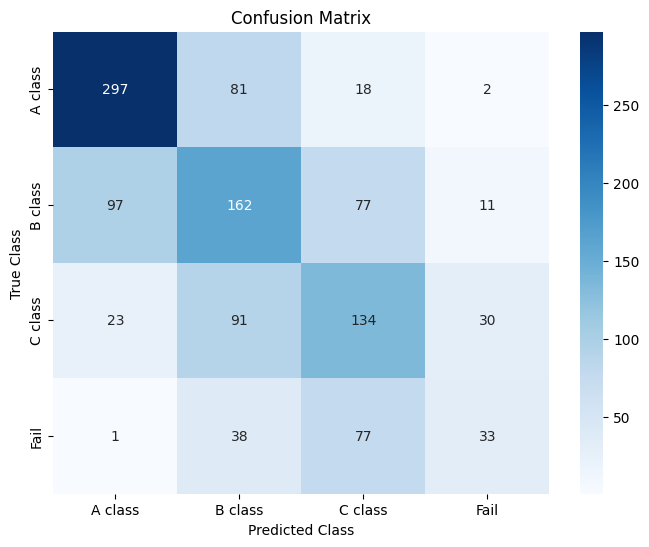

In [8]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define your custom parameters
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 4,               # Number of classes
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 10,
    'n_estimators': 500,
    'subsample': 0.8,
    'seed': 42
}

# Initialize the XGBoost classifier with your parameters
xgb_classifier = xgb.XGBClassifier(**params)

# Fit the model to the training data
xgb_classifier.fit(X_train, y_train)

# Predict on the test set
y_test_pred = xgb_classifier.predict(X_dev)

# Evaluate the model performance
accuracy = accuracy_score(y_dev, y_test_pred)
conf_matrix = confusion_matrix(y_dev, y_test_pred)

# Define class names for better readability
class_names = ['A class', 'B class', 'C class', 'Fail']

# Modify classification report with class names
class_report = classification_report(y_dev, y_test_pred, target_names=class_names)

# Print evaluation results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


Top 20 Features by Importance:
     Feature  Importance
65   CHM2046    0.030836
63   CHM2045    0.006577
5    AFR2001    0.004559
136  FRE1120    0.004370
210  LIS4785    0.004300
244  MHS4703    0.004171
15   ANT3610    0.004061
333  SPC3710    0.004046
215  LIT3353    0.003912
203  LAH2020    0.003843
254  MUL3011    0.003799
120  ENG4674    0.003731
213  LIT3103    0.003729
101  EGN3311    0.003711
240  MHS2031    0.003656
22   ARH2051    0.003650
1    ACG2071    0.003649
306  POS2041    0.003648
315  REL2166    0.003603
3    AFA4335    0.003601


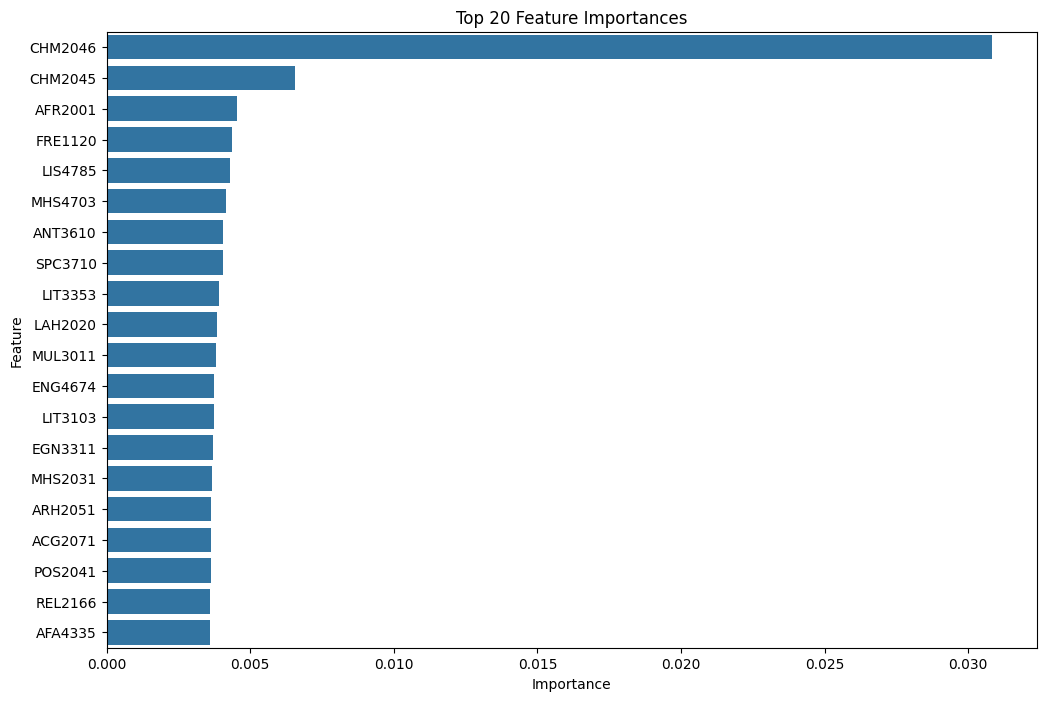

In [9]:
# Get feature importances from the trained model
feature_importances = xgb_classifier.feature_importances_

# Assuming your feature names are in X_train.columns
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top 20 features
print("Top 20 Features by Importance:")
print(importance_df.head(20))

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
